[Reference](https://medium.com/spero-engineering/fraud-detection-unsupervised-anomaly-detection-1fedc2b345b1)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/MyDrive/Medium

Mounted at /content/drive
/content/drive/MyDrive/Medium


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, classification_report
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam

%matplotlib inline

In [ ]:
df = pd.read_csv("./creditcard.csv")
df.shape

(284807, 31)

In [ ]:
df["Time"] = df["Time"].apply(lambda x : x / 3600 % 24)

In [ ]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Time,284807.0,1.453795e+01,5.847061,0.000000,10.598194,15.010833,19.329722,23.999444
V1,284807.0,3.919560e-15,1.958696,-56.407510,-0.920373,0.018109,1.315642,2.454930
V2,284807.0,5.688174e-16,1.651309,-72.715728,-0.598550,0.065486,0.803724,22.057729
V3,284807.0,-8.769071e-15,1.516255,-48.325589,-0.890365,0.179846,1.027196,9.382558
V4,284807.0,2.782312e-15,1.415869,-5.683171,-0.848640,-0.019847,0.743341,16.875344
V5,284807.0,-1.552563e-15,1.380247,-113.743307,-0.691597,-0.054336,0.611926,34.801666
V6,284807.0,2.010663e-15,1.332271,-26.160506,-0.768296,-0.274187,0.398565,73.301626
V7,284807.0,-1.694249e-15,1.237094,-43.557242,-0.554076,0.040103,0.570436,120.589494
V8,284807.0,-1.927028e-16,1.194353,-73.216718,-0.208630,0.022358,0.327346,20.007208
V9,284807.0,-3.137024e-15,1.098632,-13.434066,-0.643098,-0.051429,0.597139,15.594995


In [ ]:
df['Class'].value_counts()

0    284315
1       492
Name: Class, dtype: int64

In [ ]:
nan_mean = df.isna().mean()
nan_mean = nan_mean[nan_mean != 0].sort_values()
nan_mean

Series([], dtype: float64)

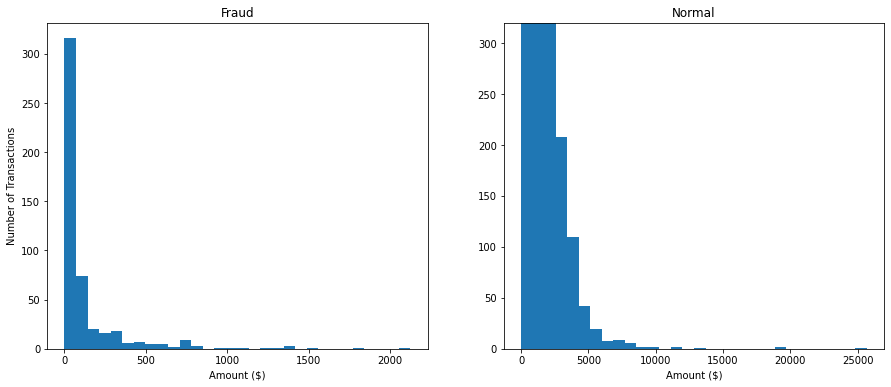

In [ ]:
# amount comparison - How different is the amount of money used in different transaction classes?

df_fraud = df[df['Class'] == 1]
df_ok = df[df['Class'] == 0]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
bins = 30

ax1.hist(df_fraud['Amount'], bins=bins)
ax2.hist(df_ok['Amount'], bins=bins)

ax1.set_title('Fraud')
ax2.set_title('Normal')

ax1.set_xlabel('Amount ($)')
ax2.set_xlabel('Amount ($)')
ax1.set_ylabel('Number of Transactions')

ax2.set_ylim(0, 320)
plt.show()

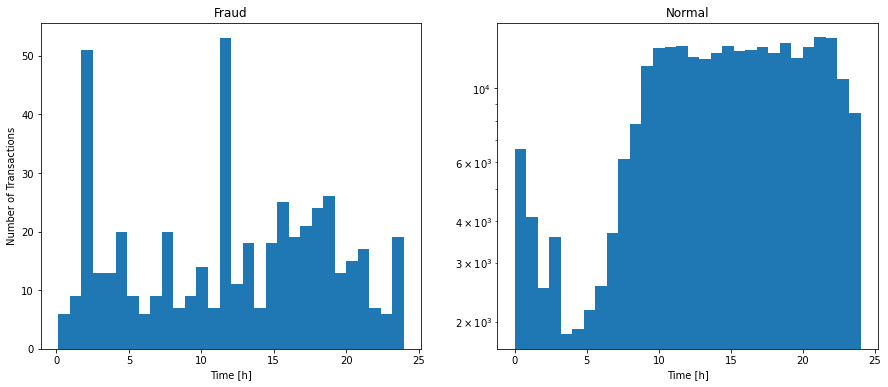

In [ ]:
# time comparison - Do fraudulent transactions occur more often during a certain frames?

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
bins = 30

ax1.hist(df_fraud['Time'], bins=bins)
ax2.hist(df_ok['Time'], bins=bins)

ax1.set_title('Fraud')
ax2.set_title('Normal')

ax1.set_xlabel('Time [h]')
ax2.set_xlabel('Time [h]')
ax1.set_ylabel('Number of Transactions')

ax2.set_yscale('log')
plt.show()

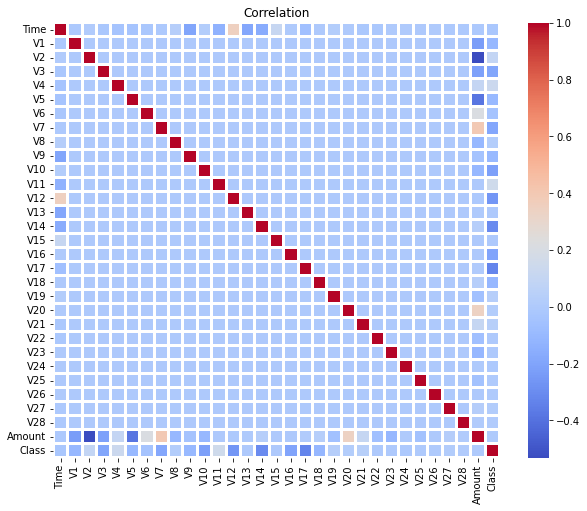

In [ ]:
corr = df.corr()

plt.figure(figsize = (10,8))
sns.heatmap(corr, cmap = "coolwarm", linewidth = 2, linecolor = "white")
plt.title("Correlation")
plt.show()

In [ ]:
ok_sample = df[df['Class'] == 0].sample(2000)
df_tsne = ok_sample.append(df_fraud).sample(frac=1).reset_index(drop=True)

In [ ]:

X_tsne = df_tsne.drop(['Class'], axis = 1).values
y_tsne = df_tsne["Class"].values

tsne = TSNE(n_components=2, random_state=42, n_jobs=-1)
X_tsne = tsne.fit_transform(X_tsne)

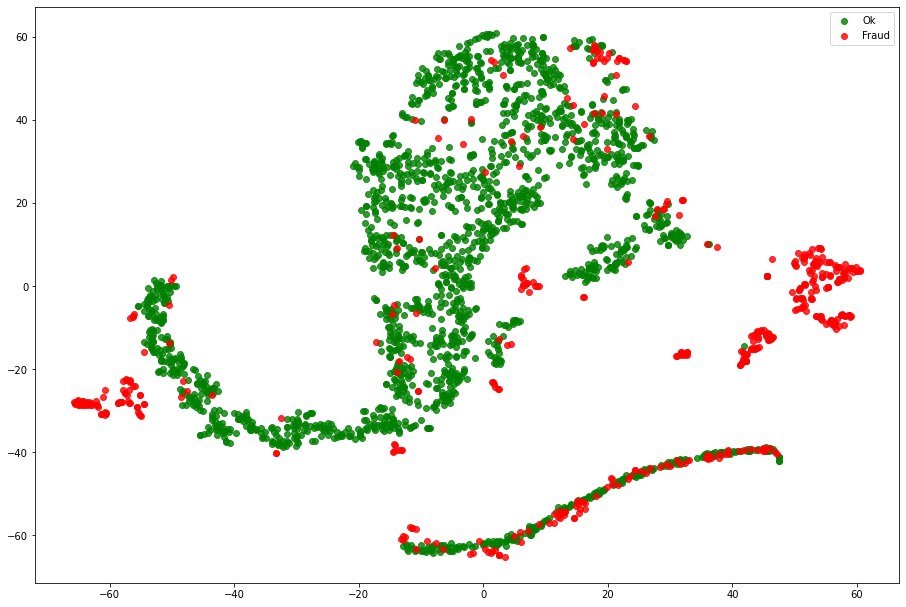

In [ ]:
fig = plt.figure(figsize=(12, 8))
ax = fig.add_axes([0, 0, 1, 1])
ax.scatter(X_tsne[np.where(y_tsne == 0), 0], X_tsne[np.where(y_tsne == 0), 1],
           marker='o', color='g', linewidth='1', alpha=0.8, label='Ok')
ax.scatter(X_tsne[np.where(y_tsne == 1), 0], X_tsne[np.where(y_tsne == 1), 1],
           marker='o', color='r', linewidth='1', alpha=0.8, label='Fraud')
ax.legend(loc='best')

In [ ]:
X = df.drop('Class', axis=1)
y = df['Class']

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)
X_train.shape, X_val.shape

((227845, 30), (56962, 30))

# Using a PCA

In [ ]:
scores = []
for n in range(2, 31):
    pca = PCA(n_components=n)
    pca.fit(X_train)
    X_tt = pca.transform(X_train)
    X_dt = pca.inverse_transform(X_tt)
    
    scores.append(mean_squared_error(X_train, X_dt))
scores = np.array(scores)
print(scores.argmin() + 2)

30


In [ ]:
n_components = 10
pca = PCA(n_components=n_components)

pca.fit(X_train)

PCA(copy=True, iterated_power='auto', n_components=10, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

# Train eval

In [ ]:
X_tt = pca.transform(X_train)
X_dt = pca.inverse_transform(X_tt)
X_dt = pd.DataFrame(X_dt, columns=X_train.columns, index=X_train.index)

reconstruction_score = []
for idx in X_train.index:
    score = mean_squared_error(X_train.loc[idx], X_dt.loc[idx])
    reconstruction_score.append(score)
    
rc_scores = pd.DataFrame(reconstruction_score, index=X_train.index, columns=['reconstruction_score'])

rec_mean = rc_scores['reconstruction_score'].mean()
rec_median = rc_scores['reconstruction_score'].median()
rec_std = rc_scores['reconstruction_score'].std()

rc_scores = rc_scores.sort_values(by='reconstruction_score', ascending=False)

top_scores_idx = rc_scores[(rc_scores > (rec_median + 2*rec_std))].dropna().index
train_fraud_index = list(y_train[y_train == 1].index)

Text(0, 0.5, 'Number of samples')

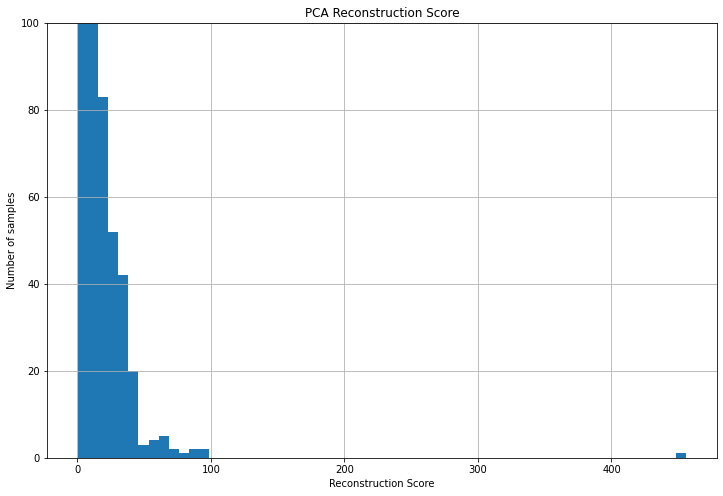

In [ ]:
plt.figure(figsize=(12, 8))
rc_scores['reconstruction_score'].hist(bins=60)
plt.ylim(0, 100)
plt.title('PCA Reconstruction Score')
plt.xlabel('Reconstruction Score')
plt.ylabel('Number of samples')

In [ ]:
pred = pd.DataFrame(index=X_train.index)
pred['fraud'] = 0
for x in top_scores_idx:
    pred['fraud'].loc[x] = 1

print(classification_report(y_train, pred['fraud']))
print('Rate of transations to investigate:', len(top_scores_idx) / len(X_train) * 100, '%')

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    227451
           1       0.21      0.65      0.32       394

    accuracy                           1.00    227845
   macro avg       0.61      0.82      0.66    227845
weighted avg       1.00      1.00      1.00    227845

Rate of transations to investigate: 0.5306238890473787 %


# Val eval

In [ ]:
X_tt = pca.transform(X_val)
X_dt = pca.inverse_transform(X_tt)
X_dt = pd.DataFrame(X_dt, columns=X_val.columns, index=X_val.index)

reconstruction_score = []
for idx in X_val.index:
    score = mean_squared_error(X_val.loc[idx], X_dt.loc[idx])
    reconstruction_score.append(score)
    
rc_scores = pd.DataFrame(reconstruction_score, index=X_val.index, columns=['reconstruction_score'])

rec_mean = rc_scores['reconstruction_score'].mean()
rec_median = rc_scores['reconstruction_score'].median()
rec_std = rc_scores['reconstruction_score'].std()

rc_scores = rc_scores.sort_values(by='reconstruction_score', ascending=False)

top_scores_idx = rc_scores[(rc_scores > (rec_median + 2*rec_std))].dropna().index
val_fraud_index = list(y_val[y_val == 1].index)

In [ ]:
pred = pd.DataFrame(index=X_val.index)
pred['fraud'] = 0
for x in top_scores_idx:
    pred['fraud'].loc[x] = 1
    
print(classification_report(y_val, pred['fraud']))
print('Rate of transations to investigate:', len(top_scores_idx) / len(X_val) * 100, '%')

              precision    recall  f1-score   support

           0       1.00      0.99      1.00     56864
           1       0.19      0.76      0.30        98

    accuracy                           0.99     56962
   macro avg       0.59      0.87      0.65     56962
weighted avg       1.00      0.99      1.00     56962

Rate of transations to investigate: 0.6987114216495207 %


# Tsne from pca representation

In [ ]:
X_pca_tsne = pca.transform(X_train)
X_pca_tsne = pd.DataFrame(X_pca_tsne, index=X_train.index)

X_pca_tsne['Class'] = y_train
ok_sample = X_pca_tsne[X_pca_tsne['Class'] == 0].sample(2000)
df_fraud = X_pca_tsne[X_pca_tsne['Class'] == 1]
df_tsne = ok_sample.append(df_fraud).sample(frac=1).reset_index(drop=True)

X_tsne = df_tsne.values
y_tsne = df_tsne["Class"].values

tsne = TSNE(n_components=2, random_state=42, n_jobs=-1)
X_tsne = tsne.fit_transform(X_tsne)

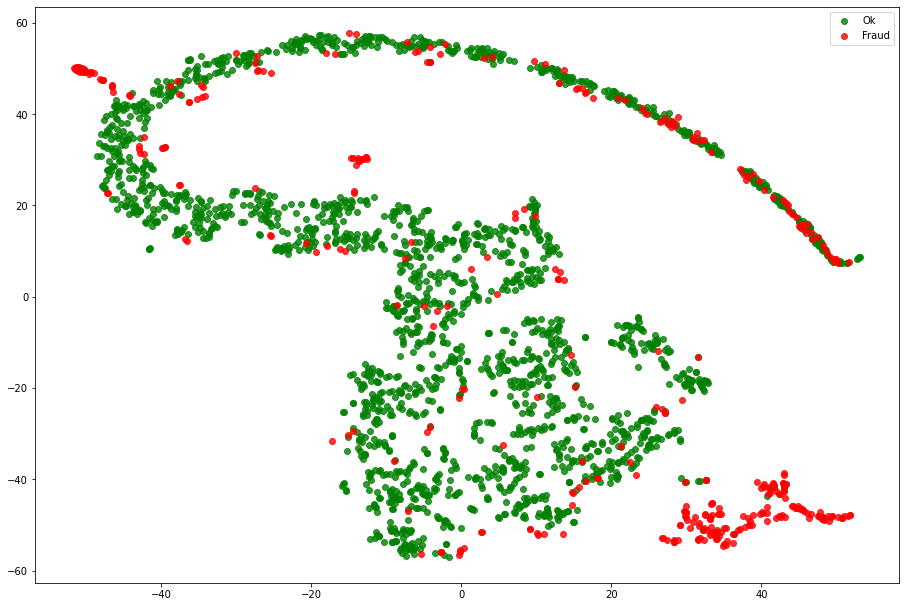

In [ ]:
fig = plt.figure(figsize=(12, 8))
ax = fig.add_axes([0, 0, 1, 1])
ax.scatter(X_tsne[np.where(y_tsne == 0), 0], X_tsne[np.where(y_tsne == 0), 1],
           marker='o', color='g', linewidth='1', alpha=0.8, label='Ok')
ax.scatter(X_tsne[np.where(y_tsne == 1), 0], X_tsne[np.where(y_tsne == 1), 1],
           marker='o', color='r', linewidth='1', alpha=0.8, label='Fraud')
ax.legend(loc='best')

# Using a Autoencoder

In [ ]:
ss = StandardScaler()
X_tscaled = ss.fit_transform(X_train.values)
X_train = pd.DataFrame(X_tscaled, columns=X_train.columns, index=X_train.index)

X_vscaled = ss.transform(X_val.values)
X_val = pd.DataFrame(X_vscaled, columns=X_val.columns, index=X_val.index)

In [ ]:
# input
inp = Input(shape=(X.shape[1],))

# Encoder
x = Dense(100, activation='relu')(inp)
x = Dense(50, activation='relu')(x)

# Decoder
x = Dense(50, activation='tanh')(x)
x = Dense(100, activation='tanh')(x)

## output
output = Dense(X.shape[1], activation='relu')(x)

autoencoder = Model(inp, output)

lr = 0.0001
epochs = 300
adam = Adam(lr=lr, decay=(lr/epochs))

autoencoder.compile(optimizer=adam, loss="mean_squared_error")
autoencoder.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 30)]              0         
_________________________________________________________________
dense (Dense)                (None, 100)               3100      
_________________________________________________________________
dense_1 (Dense)              (None, 50)                5050      
_________________________________________________________________
dense_2 (Dense)              (None, 50)                2550      
_________________________________________________________________
dense_3 (Dense)              (None, 100)               5100      
_________________________________________________________________
dense_4 (Dense)              (None, 30)                3030      
Total params: 18,830
Trainable params: 18,830
Non-trainable params: 0
_________________________________________________________

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
history = autoencoder.fit(X_train.values, X_train.values, batch_size=2048, epochs=epochs,
                          shuffle=True, verbose=0)

Text(0.5, 1.0, 'Training and validation loss')

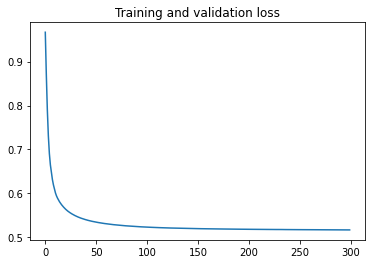

In [ ]:
loss = history.history['loss']

ts = range(epochs)

plt.plot(ts, loss)
plt.title('Training and validation loss')

In [ ]:
encoder = Sequential()
encoder.add(autoencoder.layers[0])
encoder.add(autoencoder.layers[1])
encoder.add(autoencoder.layers[2])

decoder = Sequential()
decoder.add(autoencoder.layers[3])
decoder.add(autoencoder.layers[4])
decoder.add(autoencoder.layers[5])

# Train eval

In [ ]:
X_tt = encoder.predict(X_train)
X_dt = decoder.predict(X_tt)
X_dt = pd.DataFrame(X_dt, columns=X_train.columns, index=X_train.index)

reconstruction_score = []
for idx in X_train.index:
    score = mean_squared_error(X_train.loc[idx], X_dt.loc[idx])
    reconstruction_score.append(score)
    
rc_scores = pd.DataFrame(reconstruction_score, index=X_train.index, columns=['reconstruction_score'])

rec_mean = rc_scores['reconstruction_score'].mean()
rec_median = rc_scores['reconstruction_score'].median()
rec_std = rc_scores['reconstruction_score'].std()
rc_scores = rc_scores.sort_values(by='reconstruction_score', ascending=False)

top_scores_idx = rc_scores[(rc_scores > (rec_median + 2*rec_std))].dropna().index
train_fraud_index = list(y_train[y_train == 1].index)

In [ ]:
pred = pd.DataFrame(index=X_train.index)
pred['fraud'] = 0
for x in top_scores_idx:
    pred['fraud'].loc[x] = 1
    
print(classification_report(y_train, pred['fraud']))
print('Rate of transations to investigate:', len(top_scores_idx) / len(X_train) * 100, '%')

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    227451
           1       0.17      0.58      0.27       394

    accuracy                           0.99    227845
   macro avg       0.59      0.79      0.63    227845
weighted avg       1.00      0.99      1.00    227845

Rate of transations to investigate: 0.5723189010072637 %


Text(0, 0.5, 'Number of samples')

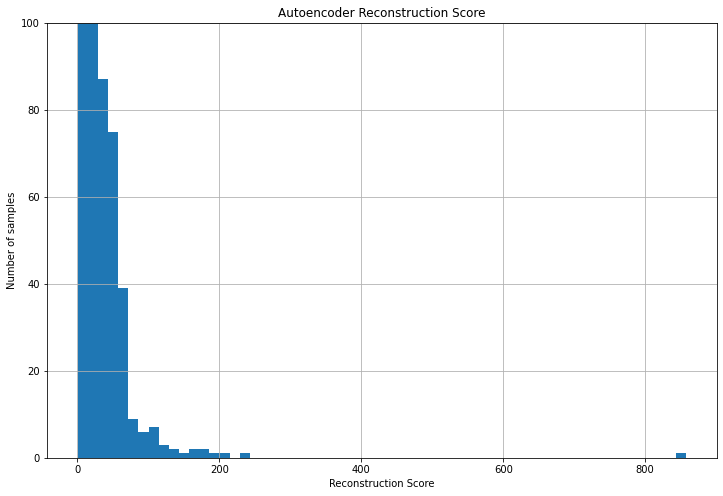

In [ ]:
plt.figure(figsize=(12, 8))
rc_scores['reconstruction_score'].hist(bins=60)
plt.ylim(0, 100)
plt.title('Autoencoder Reconstruction Score')
plt.xlabel('Reconstruction Score')
plt.ylabel('Number of samples')

# val eval

In [ ]:
X_tt = encoder.predict(X_val)
X_dt = decoder.predict(X_tt)
X_dt = pd.DataFrame(X_dt, columns=X_val.columns, index=X_val.index)

reconstruction_score = []
for idx in X_val.index:
    score = mean_squared_error(X_val.loc[idx], X_dt.loc[idx])
    reconstruction_score.append(score)
    
rc_scores = pd.DataFrame(reconstruction_score, index=X_val.index, columns=['reconstruction_score'])

rec_mean = rc_scores['reconstruction_score'].mean()
rec_median = rc_scores['reconstruction_score'].median()
rec_std = rc_scores['reconstruction_score'].std()
rc_scores = rc_scores.sort_values(by='reconstruction_score', ascending=False)

top_scores_idx = rc_scores[(rc_scores > (rec_median + 2*rec_std))].dropna().index
train_fraud_index = list(y_train[y_train == 1].index)

In [ ]:
pred = pd.DataFrame(index=X_val.index)
pred['fraud'] = 0
for x in top_scores_idx:
    pred['fraud'].loc[x] = 1

print(classification_report(y_val, pred['fraud']))
print('Rate of transations to investigate:', len(top_scores_idx) / len(X_val) * 100, '%')

              precision    recall  f1-score   support

           0       1.00      0.99      1.00     56864
           1       0.13      0.65      0.22        98

    accuracy                           0.99     56962
   macro avg       0.57      0.82      0.61     56962
weighted avg       1.00      0.99      0.99     56962

Rate of transations to investigate: 0.8514448228643657 %


# TSNE

In [ ]:
X_enc_tsne = encoder.predict(X_train)
X_enc_tsne = pd.DataFrame(X_enc_tsne, index=X_train.index)

X_enc_tsne['Class'] = y_train
ok_sample = X_enc_tsne[X_enc_tsne['Class'] == 0].sample(2000)
df_fraud = X_enc_tsne[X_enc_tsne['Class'] == 1]
df_tsne = ok_sample.append(df_fraud).sample(frac=1).reset_index(drop=True)

X_tsne = df_tsne.values
y_tsne = df_tsne["Class"].values

tsne = TSNE(n_components=2, random_state=42, n_jobs=-1)
X_tsne = tsne.fit_transform(X_tsne)

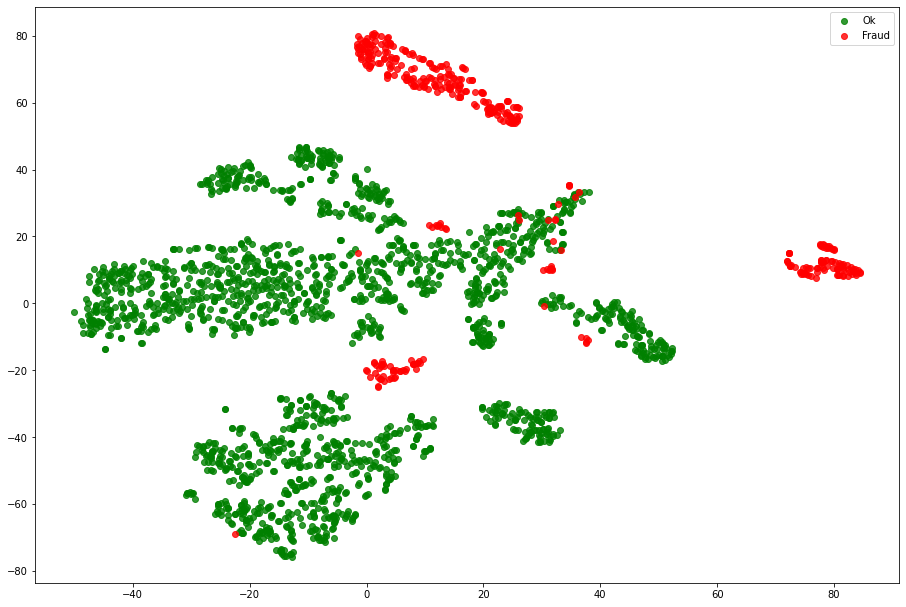

In [ ]:
fig = plt.figure(figsize=(12, 8))
ax = fig.add_axes([0, 0, 1, 1])
ax.scatter(X_tsne[np.where(y_tsne == 0), 0], X_tsne[np.where(y_tsne == 0), 1],
           marker='o', color='g', linewidth='1', alpha=0.8, label='Ok')
ax.scatter(X_tsne[np.where(y_tsne == 1), 0], X_tsne[np.where(y_tsne == 1), 1],
           marker='o', color='r', linewidth='1', alpha=0.8, label='Fraud')
ax.legend(loc='best')